In [3]:
# Import basic libraries
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Import PyTorch
import torch # import main library
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo


In [4]:

# helper function to train a model
def train_model(model, trainloader, epochs = 5):
    '''
    Function trains the model and prints out the training log.
    INPUT:
        model - initialized PyTorch model ready for training.
        trainloader - PyTorch dataloader for training data.
    '''
    #setup training

    #define loss function
    criterion = nn.NLLLoss()
    #define learning rate
    learning_rate = 0.003
    
    #initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #run training and print out the loss to make sure that we are actually fitting to the training set
    print('Training the model. Make sure that loss decreases after each epoch.\n')
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)
            log_ps = model(images)
            loss = criterion(log_ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        else:
            # print out the loss to make sure it is decreasing
            print(f"Training loss: {running_loss}")


# Parametrizable Activation Functions
We wish to create new activation functions that are trainable

Read more on:
- Bingham, G., & Miikkulainen, R. (2020). Discovering Parametric Activation Functions. ArXiv.org. https://arxiv.org/abs/2006.03179v4
- Deis, A. (2019, June 27). Extending PyTorch with Custom Activation Functions - Towards Data Science. Medium; Towards Data Science. https://towardsdatascience.com/extending-pytorch-with-custom-activation-functions-2d8b065ef2fa


1. Adding a new soft exponential

In [5]:
class soft_exponential(nn.Module):
    '''
    Implementation of soft exponential activation.
    code based on Deis, A. (2019)
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Parameters:
        - alpha - trainable parameter
    References:
        - See related paper:
        https://arxiv.org/pdf/1602.01321.pdf
    Examples:
        >>> a1 = soft_exponential(256)
        >>> x = torch.randn(256)
        >>> x = a1(x)
    '''
    def __init__(self, in_features, alpha = None):
        '''
        Initialization.
        INPUT:
            - in_features: shape of the input
            - aplha: trainable parameter
            aplha is initialized with zero value by default
        '''
        super(soft_exponential,self).__init__()
        self.in_features = in_features

        # initialize alpha
        if alpha == None:
            self.alpha = Parameter(torch.tensor(0.0)) # create a tensor out of alpha
        else:
            self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha
            
        self.alpha.requiresGrad = True # set requiresGrad to true!

    def forward(self, x):
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''
        if (self.alpha == 0.0):
            return x

        if (self.alpha < 0.0):
            return - torch.log(1 - self.alpha * (x + self.alpha)) / self.alpha

        if (self.alpha > 0.0):
            return (torch.exp(self.alpha * x) - 1)/ self.alpha + self.alpha



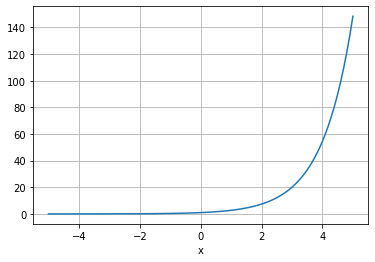

In [7]:
# data generation
import numpy as np

def function_random(x):
    return np.cosh(x) + np.sinh(x)

x = np.linspace(-5,5,100)
y_true = function_random(x)

plt.plot(x, y_true)
plt.grid()
plt.xlabel('x')
plt.show()

In [8]:
class myNet(nn.Module):
    """
    red neuronal con soft exponential
    """

    def __init__(self):
        super(myNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 50), #A1
            soft_exponential(in_features=10),
            nn.Linear(50, 100), 
            soft_exponential(in_features=10),
            nn.Linear(100,1), #A3
        )
    def forward(self, X):
        return self.layers(X)

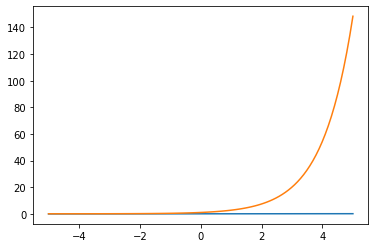

In [9]:
X = torch.tensor(x, dtype=torch.float32).reshape(-1,1)

model = myNet()
y_pred = model.forward(X)

plt.plot(X, y_pred.detach(), label='prediction')
plt.plot(X, y_true, label='true')

In [10]:
from torch.utils.data import DataLoader



trainloader = DataLoader(training_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data, batch_size=64, shuffle=True)

NameError: name 'training_data' is not defined

In [27]:
train_model(model, trainloader, epochs = 5)

torch.dtype